## Earthquake Magnitude Scale 

[https://www.mtu.edu/geo/community/seismology/learn/earthquake-measure/magnitude/](https://www.mtu.edu/geo/community/seismology/learn/earthquake-measure/magnitude/)

| Magnitude     | Earthquake Effects                                                               | Estimated Number Each Year |
|---------------|----------------------------------------------------------------------------------|-----------------------------|
| 2.5 or less   | Usually not felt, but can be recorded by seismograph.                             | Millions                    |
| 2.5 to 5.4    | Often felt, but only causes minor damage.                                        | 500,000                     |
| 5.5 to 6.0    | Slight damage to buildings and other structures.                                 | 350                         |
| 6.1 to 6.9    | May cause a lot of damage in very populated areas.                               | 100                         |
| 7.0 to 7.9    | Major earthquake. Serious damage.                                                | 10-15                       |
| 8.0 or greater| Great earthquake. Can totally destroy communities near the epicenter.           | One every year or two       |



## Earthquake Data

[https://earthquake.usgs.gov/earthquakes/search/](https://earthquake.usgs.gov/earthquakes/search/)

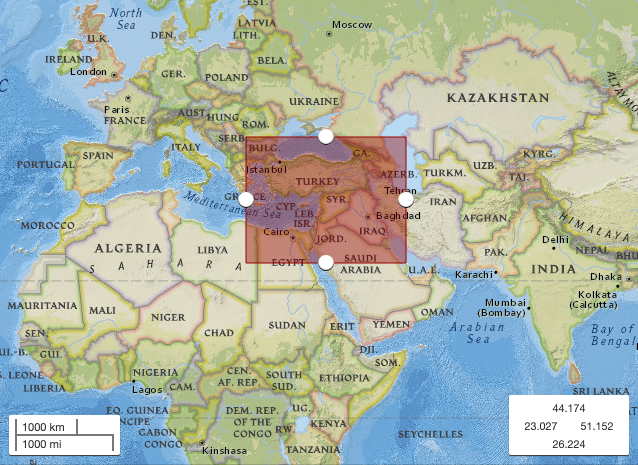

In [36]:
from IPython.display import Image
Image(filename='map.png')

In [37]:
from requests import get

url = "https://earthquake.usgs.gov/fdsnws/event/1/query.geojson?starttime=2023-03-12%2000%3A00%3A00&endtime=2023-04-12%2023%3A59%3A59&maxlatitude=44.3&minlatitude=27.79&maxlongitude=51.328&minlongitude=21.973&minmagnitude=2.5&orderby=time"
response = get(url)

if response.status_code == 200:
    response = response.json()
    features = response['features']
    print("\nSuccess!\n")
    print(f'{len(features)} earthquakes found.\n')

urlParams = dict({
    'startTime': 'starttime',
    'endTime': 'endtime',
    'maxLatitude': 'maxlatitude',
    'minLatitude': 'minlatitude',
    'maxLongitude': 'maxlongitude',
    'minLongitude': 'minlongitude',
    'minMagnitude': 'minmagnitude',
    'orderBy': 'orderby'
})



Success!

52 earthquakes found.



In [38]:
from datetime import datetime
from urllib import parse

def parse_url_segment(url, delimiter):
    return parse.unquote(url.split(delimiter)[1].split("&")[0])


def parse_url(url):
    obj = dict(urlParams)

    for key in obj:
        obj[key] = parse_url_segment(url, obj[key] + "=")

        if (key == 'startTime' or key == 'endTime'):
            obj[key] = datetime.strptime(obj[key], "%Y-%m-%d %H:%M:%S")

        if (key == 'maxLatitude' or key == 'minLatitude' or key == 'maxLongitude' or key == 'minLongitude' or key == 'minMagnitude'):
            obj[key] = float(obj[key])

    return obj

urlParams = parse_url(url)
print(urlParams)

{'startTime': datetime.datetime(2023, 3, 12, 0, 0), 'endTime': datetime.datetime(2023, 4, 12, 23, 59, 59), 'maxLatitude': 44.3, 'minLatitude': 27.79, 'maxLongitude': 51.328, 'minLongitude': 21.973, 'minMagnitude': 2.5, 'orderBy': 'time'}


In [39]:
# input
YEARS_TO_COLLECT = 20
MIN_MAGNITUDE = 0
FILE_NAME = 'earthquakes.csv'

In [40]:
from datetime import timedelta

urlParams['minMagnitude'] = MIN_MAGNITUDE
urlParams['endTime'] = datetime.now()
urlParams['startTime'] = urlParams['endTime'] - \
    timedelta(weeks=YEARS_TO_COLLECT*52)

print(urlParams)

{'startTime': datetime.datetime(2003, 5, 7, 0, 11, 35, 455468), 'endTime': datetime.datetime(2023, 4, 12, 0, 11, 35, 455468), 'maxLatitude': 44.3, 'minLatitude': 27.79, 'maxLongitude': 51.328, 'minLongitude': 21.973, 'minMagnitude': 0, 'orderBy': 'time'}


In [41]:

import pandas as pd

df = pd.DataFrame(columns=['magnitude',
                  'time', 'latitude', 'longitude', 'depth'])


def append_earthquakes_to_dataframe(features):
    for earthquake in features:
        magnitude = earthquake['properties']['mag']
        time = earthquake['properties']['time']
        latitude = earthquake['geometry']['coordinates'][1]
        longitude = earthquake['geometry']['coordinates'][0]
        depth = earthquake['geometry']['coordinates'][2]

        df.loc[len(df)] = [magnitude, time, latitude, longitude, depth]


def get_earthquake_data(urlParams: dict[urlParams]):
    timeStep = urlParams['endTime'] - urlParams['startTime']
    stepParams = dict(urlParams)
    while True:
        stepParams['startTime'] = stepParams['endTime'] - timeStep

        url = f"https://earthquake.usgs.gov/fdsnws/event/1/query.geojson?starttime={stepParams['startTime']}&endtime={stepParams['endTime']}&maxlatitude={stepParams['maxLatitude']}&minlatitude={stepParams['minLatitude']}&maxlongitude={stepParams['maxLongitude']}&minlongitude={stepParams['minLongitude']}&minmagnitude={stepParams['minMagnitude']}&orderby={stepParams['orderBy']}"
        response = get(url)

        if response.status_code == 400 and "matching events exceeds search limit" in response.text:
            print('search limit reached, timestep reduced')
            timeStep = timedelta(seconds=timeStep.total_seconds() / 2)
            continue

        if response.status_code != 200:
            print("Error: ", response.status_code)
            print(response.text)
            break

        append_earthquakes_to_dataframe(response.json()['features'])

        stepParams['endTime'] = stepParams['startTime']
        if (stepParams['endTime'] < urlParams['startTime']):
            break


get_earthquake_data(urlParams)

df.to_csv(FILE_NAME)
print(f'\n{len(df)} earthquakes successfully exported to `{FILE_NAME}`.')


search limit reached, timestep reduced

35733 earthquakes successfully exported to `earthquakes.csv`.


In [1]:
# input
FILE_NAME = 'earthquakes.csv'

In [ ]:
import pandas as pd

df = pd.read_csv(FILE_NAME, index_col=0)

In [4]:

import ydata_profiling as ydp

profile = ydp.ProfileReport(df)

profile.to_file("profile_report.html")

profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]